In [1]:
#importing libraries
import pandas as pd
import numpy as np
import swifter
import operator, functools
import ast
import matplotlib.pyplot as plt

In [ ]:
######TASK 1########

In [2]:
#read data
TakeHomeData = pd.read_csv('takeHome.csv')

In [3]:
#check missing values - sanity check
TakeHomeData.isna().sum()

ltv      1
ttime    0
abt      0
tue      2
dtype: int64

In [4]:
TakeHomeData

,ltv,ttime,abt,tue
0,"{""n"":""250""}","{""n"":""1077572""}","{""n"":""31""}","{""n"":""38""}"
1,"{""n"":""49""}","{""n"":""60028""}","{""n"":""32""}","{""n"":""15""}"
2,"{""n"":""680""}","{""n"":""2018285""}","{""n"":""7""}","{""n"":""46""}"
3,"{""n"":""125""}","{""n"":""98142""}","{""n"":""11""}","{""n"":""15""}"
4,"{""n"":""450""}","{""n"":""115692""}","{""n"":""9""}","{""n"":""15""}"
...,...,...,...,...
9994,"{""n"":""250""}","{""n"":""4002074""}","{""n"":""23""}","{""n"":""127""}"
9995,"{""n"":""250""}","{""n"":""2134787""}","{""n"":""28""}","{""n"":""53""}"
9996,"{""n"":""150""}","{""n"":""107426""}","{""n"":""53""}","{""n"":""15""}"
9997,"{""n"":""72""}","{""n"":""0""}","{""n"":""26""}","{""n"":""15""}"


In [5]:
#check dtypes values - sanity check
TakeHomeData.dtypes

ltv      object
ttime    object
abt      object
tue      object
dtype: object

In [6]:
#clean values - sanity check
TakeHomeData= TakeHomeData.fillna('{"n":"0"}')
TakeHomeData['ltv'] = TakeHomeData['ltv'].swifter.apply(lambda x: ast.literal_eval(x))
TakeHomeData['ttime'] = TakeHomeData['ttime'].swifter.apply(lambda x: ast.literal_eval(x))
TakeHomeData['abt'] = TakeHomeData['abt'].swifter.apply(lambda x: ast.literal_eval(x))
TakeHomeData['tue'] = TakeHomeData['tue'].swifter.apply(lambda x: ast.literal_eval(x))

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [7]:
#extract data
get_values = functools.partial(map, operator.itemgetter('n'))
a = pd.DataFrame(get_values(TakeHomeData['ltv'])).rename(columns = {0:'ltv'})
b = pd.DataFrame(get_values(TakeHomeData['ttime'])).rename(columns = {0:'ttime'})
c = pd.DataFrame(get_values(TakeHomeData['abt'])).rename(columns = {0:'abt'})
d = pd.DataFrame(get_values(TakeHomeData['tue'])).rename(columns = {0:'tue'})

In [8]:
#sum up the frames and assign a singular data type
TakeHomeData_clean = pd.concat([a,b,c,d],axis = 1)
TakeHomeData_clean.iloc[:,0:4] = TakeHomeData_clean.iloc[:,0:4].astype(float)

In [9]:
#make pivot to aggregate across ab groups
q_pivot = pd.pivot_table(TakeHomeData_clean,values=['ltv','ttime','tue'],columns = ['abt'],aggfunc=sum)

In [10]:
#make transpose pivot
q_pivot = q_pivot.transpose().reset_index()

In [183]:
#compute difference
d = {}
diff = {}
map_dict = {}
j = 0
for n in range(0,max(q_pivot.index)+1):
    d[n] = pd.DataFrame(q_pivot.iloc[:, :].values - q_pivot.iloc[n:n+1, :].values)
    diff[n] = d[n][d[n][0] > 0]
    if n == 0:
        for x in range(min(list(diff[n][0])),max(list(diff[n][0]))+1):
            map_dict[x] = f'1-{x+1}'
        j += 1
    if j == 59:
        break
    if n ==j:
        for x in range(min(list(diff[n][0])),max(list(diff[n][0]))+1):
            map_dict[x] = f'{j+1}-{x+j+1}'
        j += 1
    diff[n][0] = diff[n][0].map(map_dict)
    map_dict = {}

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [205]:
#concat difference dataframes
df = pd.DataFrame()
for y in range(0,max(q_pivot.index)):
    df = pd.concat([df,diff[y]],axis = 0)

In [206]:
#renaming dataframes
df = df.rename(columns = {0:'abt_diff',1:'ltv_diff',2:'ttime_diff',3:'tue_diff'})

In [207]:
#taking absolute values
df[['ltv_diff','ttime_diff','tue_diff']] = df[['ltv_diff','ttime_diff','tue_diff']].abs()

In [208]:
df

,abt_diff,ltv_diff,ttime_diff,tue_diff
1,1-2,25040,6188567377,66898
2,1-3,4337,1072572966,22509
3,1-4,18332,4335553509,61089
4,1-5,1159,934193425,11308
5,1-6,3456,1202475854,11575
...,...,...,...,...
58,57-59,1994,76495972,147
59,57-60,3195,1610577292,15932
58,58-59,14801,385397038,10465
59,58-60,19990,1301676226,5320


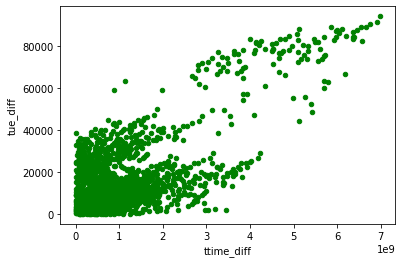

In [213]:
#tue_diff is in positive correlation with ttime_diff
df.plot(kind='scatter',x='ttime_diff',y='tue_diff',color='green')

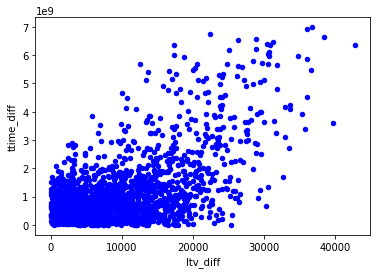

In [214]:
#ltv_diff is in positive correlation with ttime_diff
df.plot(kind='scatter',x='ltv_diff',y='ttime_diff',color='blue')

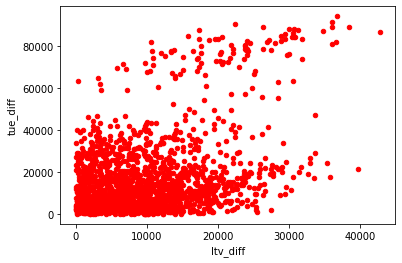

In [211]:
#ltv_diff and tue_diff are positively correlated but not strongly correlated
df.plot(kind='scatter',x='ltv_diff',y='tue_diff',color='red')

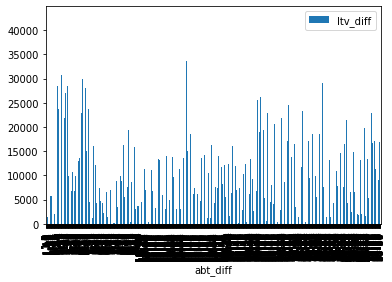

In [217]:
#data points are evenly distributed across all groups
df.plot(kind='bar',x='abt_diff',y=['ltv_diff'])

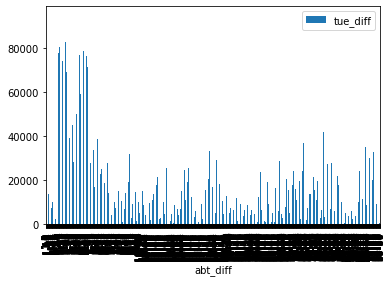

In [218]:
#data points are skewed for tue_diff in first 20 categories
df.plot(kind='bar',x='abt_diff',y=['tue_diff'])

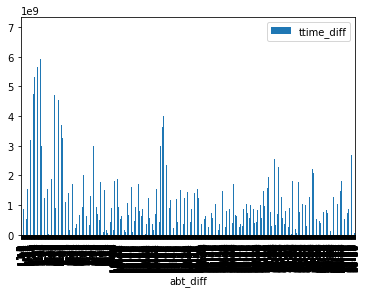

In [219]:
#data points are stale for ttime_diff in first 20 categories
df.plot(kind='bar',x='abt_diff',y=['ttime_diff'])

In [ ]:
######TASK 2########

In [129]:
econs = pd.read_csv('econs.txt',delimiter='\t')
econs

,cumGXP,cumPXP,econ,lvl,cumTime,cumUnits
0,500.0,0,Controls,1,0.10,0
1,1500.0,200,Controls,2,0.10,20
2,3500.0,600,Controls,3,0.20,60
3,6500.0,1200,Controls,4,0.30,120
4,11000.0,2000,Controls,5,0.50,200
...,...,...,...,...,...,...
135,1627550.0,169895,Econ3,36,180.84,1595
136,1743050.0,177895,Econ3,37,193.67,1595
137,1863050.0,185895,Econ3,38,207.01,1595
138,1987550.0,193895,Econ3,39,220.84,1595


In [130]:
sts = pd.read_csv('sts.csv')
sts

,state,sts
0,"{""n"":""1""}","{""m"":{""com.utorrent.client.pro"":{""m"":{""d30"":{""..."
1,"{""n"":""1""}","{""m"":{""com.tetherstudios.solitaire.klondike"":{..."
2,"{""n"":""0""}","{""m"":{""com.ticketmaster.mobile.android.na"":{""m..."
3,"{""n"":""0""}","{""m"":{""com.ticketmaster.mobile.android.na"":{""m..."
4,"{""n"":""1""}","{""m"":{""flipboard.boxer.app"":{""m"":{""d30"":{""n"":""..."
...,...,...
6086,"{""n"":""1""}","{""m"":{""com.trustonic.tuiservice"":{""m"":{""cat"":{..."
6087,"{""n"":""1""}","{""m"":{""com.barclays.apps.pingit"":{""m"":{""cat"":{..."
6088,"{""n"":""1""}","{""m"":{""com.fungames.sniper3d"":{""m"":{""cat"":{""s""..."
6089,"{""n"":""1""}","{""m"":{""com.fungames.sniper3d"":{""m"":{""d30"":{""n""..."


In [131]:
sts.isna().sum()

state    0
sts      0
dtype: int64

In [137]:
sts['state'] = sts['state'].swifter.apply(lambda x: ast.literal_eval(x))
state = pd.DataFrame(get_values(sts['state'])).rename(columns = {0:'state_clean'})
sts_new = pd.concat([sts,state],axis = 1).drop('state',axis = 1)
sts_new['sts'] = sts_new['sts'].swifter.apply(lambda x: ast.literal_eval(x))